In [3]:
%load_ext autoreload
%autoreload 2
from sympy import symbols, init_printing, simplify, solve
from mako.template import Template
from mako.lookup import TemplateLookup
from mako.runtime import Context
from StringIO import StringIO
from fdlib import *
init_printing()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


###Wave equation in 3D

In [2]:
dx, dt, x, y, z, t, c, h = symbols('dx dt x y z t c h')
U = IndexedBase('U')
# 2nd order approximation
n = 2
# list of variables
l = [x,y,z,t]

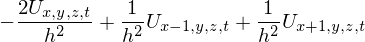

In [4]:
# get the derivative expressions
# using dx = dy = h
Uxx = Deriv(U,l,0,h,n)[2]
Uyy = Deriv(U,l,1,h,n)[2]
Uzz = Deriv(U,l,2,h,n)[2]
Utt = Deriv(U,l,3,dt,n)[2]
Uxx

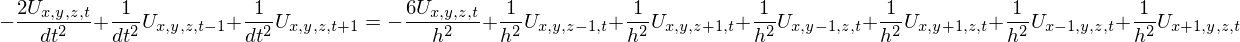

In [5]:
# 2d wave equation
eq = Eq(Utt, (Uxx+Uyy+Uzz))
eq

In [6]:
# generate C code for the body of the loop
code = print_myccode(U[x,y,z,t+1]) + "=" + print_myccode(simplify(solve(eq, U[x,y,z,t+1])[0]))
code

'U[x][y][z][t + 1]=(-6*pow(dt, 2)*U[x][y][z][t] + pow(dt, 2)*U[x][y][z - 1][t] + pow(dt, 2)*U[x][y][z + 1][t] + pow(dt, 2)*U[x][y - 1][z][t] + pow(dt, 2)*U[x][y + 1][z][t] + pow(dt, 2)*U[x - 1][y][z][t] + pow(dt, 2)*U[x + 1][y][z][t] + pow(h, 2)*(2*U[x][y][z][t] - U[x][y][z][t - 1]))/pow(h, 2)'

###Wave equation in 2D

In [7]:
l = [x,t]
Uxx = Deriv(U,l,0,h,n)[2]
Utt = Deriv(U,l,1,dt,n)[2]

In [8]:
eq = Eq(Utt, Uxx)
code = print_myccode(U[x,t+1]) + "=" + print_myccode(simplify(solve(eq, U[x,t+1])[0]))
code

'U[x][t + 1]=(-2*pow(dt, 2)*U[x][t] + pow(dt, 2)*U[x - 1][t] + pow(dt, 2)*U[x + 1][t] + pow(h, 2)*(2*U[x][t] - U[x][t - 1]))/pow(h, 2)'

In [9]:
mytemplate = Template(filename='templates/tmpl1.c')
buf = StringIO()
ctx = Context(buf, loopbody=code)
mytemplate.render_context(ctx)

In [10]:
print(buf.getvalue())

// initialisation
for(int i=0; i<=Nx; i++)
    u[i][0] = I(x[i])
// separate calculation for first time step
for(int i=1; i<Nx; i++)
    u[i][1] = u[i][0]
        -0.5*C**2(u[i+1][0] - 2*u[i][0] + u[i-1][0])
// main loop
for(int n=1; n<Nt; n++){
    // boundary conditions
    u[n+1][0] = 0; u[n+1][Nx] = 0;
    for(int i=1; i<Nx; i++)
    // update mesh points at time = n+1
        U[x][t + 1]=(-2*pow(dt, 2)*U[x][t] + pow(dt, 2)*U[x - 1][t] + pow(dt, 2)*U[x + 1][t] + pow(h, 2)*(2*U[x][t] - U[x][t - 1]))/pow(h, 2)
}



###Propagator

In [4]:
U,V,W,Txx,Tyy,Tzz,Txy,Tyz,Txz = IndexedBases('U V W Txx Tyy Tzz Txy Tyz Txz')
x,y,z,t,h,dt = symbols('x y z t h dt')
Buoyancy, Lambda, Miu = IndexedBases('Buoyancy Lambda Miu')

In [5]:
l = [x,y,z,t]

# first-order derivatives of velocities
Ut = Deriv_half(U,l,3,dt,1)[1]
Vt = Deriv_half(V,l,3,dt,1)[1]
Wt = Deriv_half(W,l,3,dt,1)[1]

Ux = Deriv_half(U,l,0,h,2)[1]
Uy = Deriv_half(U,l,1,h,2)[1]
Uz = Deriv_half(U,l,2,h,2)[1]

Vx = Deriv_half(V,l,0,h,2)[1]
Vy = Deriv_half(V,l,1,h,2)[1]
Vz = Deriv_half(V,l,2,h,2)[1]

Wx = Deriv_half(W,l,0,h,2)[1]
Wy = Deriv_half(W,l,1,h,2)[1]
Wz = Deriv_half(W,l,2,h,2)[1]

# first-order derivatives of stresses
DxTxx = Deriv_half(Txx,l,0,h,2)[1]
DyTxy = Deriv_half(Txy,l,1,h,2)[1]
DzTxz = Deriv_half(Txz,l,2,h,2)[1]

DxTxy = Deriv_half(Txy,l,0,h,2)[1]
DyTyy = Deriv_half(Tyy,l,1,h,2)[1]
DzTyz = Deriv_half(Tyz,l,2,h,2)[1]

DxTxz = Deriv_half(Txz,l,0,h,2)[1]
DyTyz = Deriv_half(Tyz,l,1,h,2)[1]
DzTzz = Deriv_half(Tzz,l,2,h,2)[1]

DtTxx = Deriv_half(Txx,l,3,dt,1)[1]
DtTxy = Deriv_half(Txy,l,3,dt,1)[1]
DtTxz = Deriv_half(Txz,l,3,dt,1)[1]
DtTyy = Deriv_half(Tyy,l,3,dt,1)[1]
DtTyz = Deriv_half(Tyz,l,3,dt,1)[1]
DtTzz = Deriv_half(Tzz,l,3,dt,1)[1]

In [6]:
# momentum equations
eq1 = Eq(Ut, Buoyancy[x,y,z]*(DxTxx + DyTxy + DzTxz))
eq2 = Eq(Vt, Buoyancy[x,y,z]*(DxTxy + DyTyy + DzTyz))
eq3 = Eq(Wt, Buoyancy[x,y,z]*(DxTxz + DyTyz + DzTzz))

In [7]:
# stress-strain equations
eq4 = Eq(DtTxx, (Lambda[x,y,z] + 2*Miu[x,y,z])*Ux + Lambda[x,y,z]*(Vy+Wz))
eq5 = Eq(DtTyy, (Lambda[x,y,z] + 2*Miu[x,y,z])*Vy + Lambda[x,y,z]*(Ux+Wz))
eq6 = Eq(DtTzz, (Lambda[x,y,z] + 2*Miu[x,y,z])*Wz + Lambda[x,y,z]*(Ux+Vy))
eq7 = Eq(DtTxy, Miu[x,y,z]*(Uy+Vx))
eq8 = Eq(DtTxz, Miu[x,y,z]*(Uz+Wx))
eq9 = Eq(DtTyz, Miu[x,y,z]*(Vz+Wy))

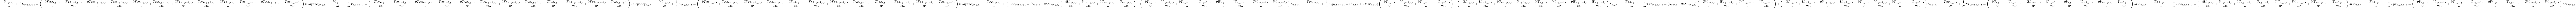

In [8]:
eqs = [eq1,eq2,eq3,eq4,eq5,eq6,eq7,eq8,eq9]; eqs

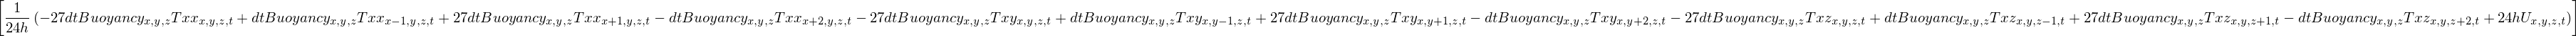

In [13]:
hf = Rational(1,2)
DxTxx
solve(eq1,U[x,y,z,t+1])

In [10]:
U_t = print_increment(eq1, U[x,y,z,t+1], U[x,y,z,t])
V_t = print_increment(eq2, V[x,y,z,t+1], V[x,y,z,t])
W_t = print_increment(eq3, W[x,y,z,t+1], W[x,y,z,t])
Txx_t = print_increment(eq4, Txx[x,y,z,t+1], Txx[x,y,z,t])
Tyy_t = print_increment(eq5, Tyy[x,y,z,t+1], Tyy[x,y,z,t])
Tzz_t = print_increment(eq6, Tzz[x,y,z,t+1], Tzz[x,y,z,t])
Txy_t = print_increment(eq7, Txy[x,y,z,t+1], Txy[x,y,z,t])
Txz_t = print_increment(eq8, Txz[x,y,z,t+1], Txz[x,y,z,t])
Tyz_t = print_increment(eq9, Tyz[x,y,z,t+1], Tyz[x,y,z,t])

In [11]:
mylookup = TemplateLookup(directories=['templates/'])
mytemplate = mylookup.get_template('test_ref_iso_elastic_tmpl.cpp')
buf = StringIO()
dict1 = {'Txx':Txx_t,'Tyy':Tyy_t,'Tzz':Tzz_t,'Txy':Txy_t,'Txz':Txz_t,'Tyz':Tyz_t,'U':U_t,'V':V_t,'W':W_t}
ctx = Context(buf, **dict1)
mytemplate.render_context(ctx)

In [12]:
print(buf.getvalue())

/*  Copyright (C) 2015 Imperial College London and others.
 *
 *  Please see the AUTHORS file in the main source directory for a
 *  full list of copyright holders.
 *
 *  Gerard Gorman
 *  Department of Earth Science and Engineering
 *  Imperial College London
 *
 *  g.gorman@imperial.ac.uk
 *
 *  Redistribution and use in source and binary forms, with or without
 *  modification, are permitted provided that the following conditions
 *  are met:
 *  1. Redistributions of source code must retain the above copyright
 *  notice, this list of conditions and the following disclaimer.
 *  2. Redistributions in binary form must reproduce the above
 *  copyright notice, this list of conditions and the following
 *  disclaimer in the documentation and/or other materials provided
 *  with the distribution.
 *
 *  THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND
 *  CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES,
 *  INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF
 *  